In [216]:
from google.colab import drive
import os

drive.mount('/content/drive')   #구글 드라이브 연결
Project_Path = '/content/drive/MyDrive/AS_LAB'  #저장할 폴더 경로 설정

#저장할 폴더 존재 여부 확인(없으면 새 폴더 생성, 있으면 기존 폴더 사용)
if not os.path.exists(Project_Path):
    os.makedirs(Project_Path)
    print(f"새 폴더 생성 후 저장 완료: {Project_Path}")
else:
    print(f"기존 폴더에 저장: {Project_Path}")

os.chdir(Project_Path)   #작업 위치 이동(change directory)

Mounted at /content/drive
기존 폴더에 저장: /content/drive/MyDrive/AS_LAB


In [ ]:
# 이 코드는 Ben Trevett의 튜토리얼을 참고하여 학습 목적으로 작성되었습니다.
# Source: https://github.com/bentrevett/pytorch-image-classification

#Data Processing
import torch #일반적인 파이토치 기능(텐서 만들기 등)
import torch.nn as nn #신경망 층 쌓을 때 사용(nn.Linear, nn.CrossEntropyLoss 등)
import torch.nn.functional as F #nn의 함수 형태 기능들 사용
import torch.optim as optim #최적화(Optimizer) 도구들
import torch.utils.data as data #데이터를 쉽게 퍼나르기 위한 도구(DataLoader를 통해 데이터를 한 번에 몇 개씩(Batch)가져올지, 섞어서 (Shuffle)가져올지 결정)

import torchvision.transforms as transforms #이미지를 변형하는 도구
import torchvision.datasets as datasets #데이터셋을 모아놓은 라이브러리(datasets.MNIST 등)

from sklearn import metrics #정확도나 혼동행렬 계산시 사용(채점표)
from sklearn import decomposition #어려운 고차원 데이터를 2차원 평면으로 압축하여 시각화할 때 사용(PCA)
from sklearn import manifold #어려운 고차원 데이터를 2차원 평면으로 압축하여 시각화할 때 사용(t-SNE)
from tqdm.notebook import trange, tqdm #진행률 표시바(Progress bar)
import matplotlib.pyplot as plt #시각화 도구
import numpy as np #수치 계산시 사용

import copy #학습 중 성능이 가장 좋았던 모델의 가중치를 복사해서 저장해둘 때 사용
import random #실험결과를 똑같이 재현하기 위해 랜덤 시드를 고정할 때 사용
import time #학습시간 측정시 사용


In [ ]:
#재현할 수 있는 결과를 얻게하기 위해 랜덤 시드 설정
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
#데이터셋 로드하기
ROOT = '.data' #데이터가 저장될 위치 지정(폴더명)
train_data = datasets.MNIST(root=ROOT, #MNIST 데이터셋을 ROOT 위치에 저장
                            train=True, #학습용 데이터 로드(6만장)
                            download=True) #ROOT 위치에 데이터셋이 이미 있다면 다운로드 하지 않고, 없으면 다운로드

In [ ]:
#평균과 표준편차 구하기
mean = train_data.data.float().mean()/255
std = train_data.data.float().std()/255

In [ ]:
print('평균: ', mean)
print('표준편차: ', std)

평균:  tensor(0.1307)
표준편차:  tensor(0.3081)


In [ ]:
#데이터 증강(Rotation, Crop, ToTensor, Normalize)
train_transforms = transforms.Compose([ #훈련용 데이터
    transforms.RandomRotation(5, fill=(0,)), #이미지를 시계/반시계 방향으로 -5도에서 +5도 사이로 랜덤하게 회전 / fill=(0,): 이미지 회전시 귀퉁이에 생기는 빈 공간 0으로 채우기
    transforms.RandomCrop(28, padding=2), #28x28 이미지 테두리에 2픽셀씩 덧붙여 32x32크기로 키운 후 28x28 크기로 무작위 추출(이미지가 상하좌우로 이동하는 효과)
    transforms.ToTensor(), #그림 파일을 Tensor로 형변환(0~255의 값이 0~1 사이의 실수로 변형)
    transforms.Normalize(mean=[mean], std=[std]) #데이터에서 평균을 빼고, 표준편차로 나누기(데이터의 분포를 0 중심으로 모아 학습 효율 극대화)
])

test_transforms = transforms.Compose([ #실험용 데이터
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [ ]:
#데이터 셋을 훈련용, 실험용으로 나누어 로드하고, 각각 데이터셋에 맞는 변형 선택
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

In [ ]:
#데이터 개수 확인
print(f'훈련용 데이터 예제 수: {len(train_data)}')
print(f'실험용 데이터 예제 수: {len(test_data)}')

훈련용 데이터 예제 수: 60000
실험용 데이터 예제 수: 10000


In [ ]:
#데이터 시각화
def plot_images(images):

    n_images = len(images) #이미지 개수

    rows = int(np.sqrt(n_images)) #이미지 개수의 제곱근
    cols = int(np.sqrt(n_images)) #이미지 개수의 제곱근

    fig = plt.figure() #그림이 그려질 곳(도화지)
    for i in range(rows*cols): #이미지 수만큼 반복
        ax = fig.add_subplot(rows, cols, i+1) #작은 그래프 하나 추가 / i+1: 그림 순서를 1번부터 세기 때문에 지정
        ax.imshow(images[i].view(28,28).cpu().numpy(), cmap='bone') #i번째 이미지 데이터를 꺼내 28x28크기의 이미지로 돌려놓고, 텐서를 CPU로 가져와서 넘파이 배열로 바꾸는 명령
        ax.axis('off') #그래프의 눈금 지우기

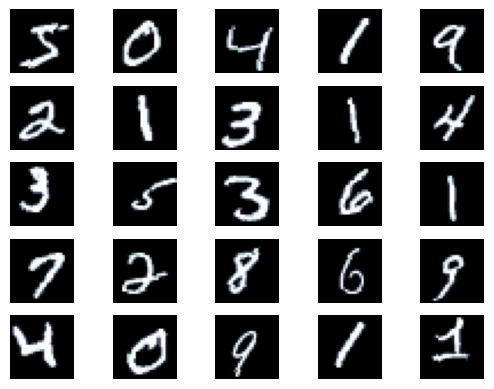

In [ ]:
#함수 테스트
N_IMAGES = 25
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
plot_images(images)

In [ ]:
#Validation Set(검증용 데이터셋) 만들기
VALID_RATIO = 0.9

n_train_examples = int(len(train_data)*VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples #train_dataset의 10%를 Validation Set으로 사용

In [ ]:
#검증용 데이터 랜덤 분할
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [ ]:
#분할 수 확인
print(f'훈련용 데이터 개수: {len(train_data)}')
print(f'검증용 데이터 개수: {len(valid_data)}')
print(f'실험용 데이터 개수: {len(test_data)}')

훈련용 데이터 개수: 54000
검증용 데이터 개수: 6000
실험용 데이터 개수: 10000


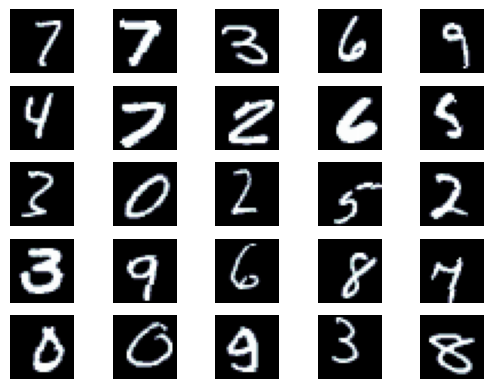

In [ ]:
#검증용 데이터셋 확인
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [ ]:
#얕은 복사 문제와 검증용 데이터셋의 변형 상태를 돌려놓기 위한 설정
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

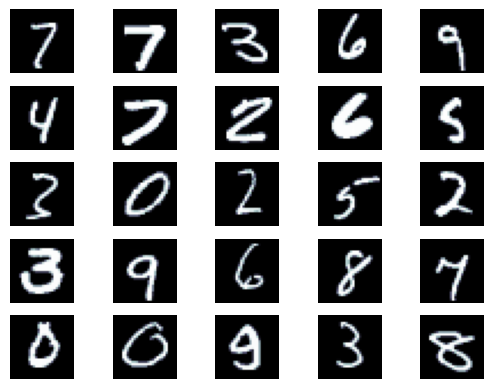

In [ ]:
#설정 확인
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [ ]:
#데이터 로더 만들기
BATCH_SIZE = 64 #한 번에 64개의 데이터를 모델에 입력하여 처리

train_iterator = data.DataLoader(train_data,
                                 shuffle=True, #매번 새로운 조합의 데이터 묶음을 보여준다.
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                  batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

shuffle=True: 훈련시에는 이미지의 순서를 보고 값을 예측하지 못하도록 매번 새로운 조합의 데이터 묶음을 보여주어 제대로 내용을 이해하도록 해준다(확률적 경사 하강법(SGD)의 핵심).

In [ ]:
#Defining the Model
#MLP 클래스 구현

class MLP(nn.Module):
    #생성자
    def __init__(self, input_dim, output_dim): #모델이 사용할 층들을 정의하는 함수
        super().__init__() #자식 클래스가 부모 클래스의 초기화 메소드를 호출하여 부모의 속성과 기능을 그대로 가져와 사용하는 코드

        self.input_fc = nn.Linear(input_dim, 250) #1층: 입력 -> 은닉층1(입력 데이터를 250차원의 특징 벡터로 변환(매핑))
        self.hidden_fc = nn.Linear(250, 100) #2층: 은닉층1 -> 은닉층2(250차원의 특징을 더 압축하여 100차원의 고급특징 벡터로 매핑)
        self.output_fc = nn.Linear(100, output_dim) #3층: 은닉층2 -> 출력(100차원의 특징 벡터를 보고 0~9까지의 클래스 확률로 변환

    #순전파 함수
    def forward(self, x): #데이터(x)가 실제로 들어왔을 때 모델을 어떤 순서로 통과할지 결정

        #현재 x = [batch size, height, width]

        #평탄화
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        #현재 x = [batch size, height*width]

        h_1 = F.relu(self.input_fc(x)) #784차원의 입력 벡터를 250차원의 특징 벡터로 변환(숫자의 기초적인 특징, ReLU를 이용해 불필요한 정보는 삭제)

        #은닉층1 h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1)) #250차원의 특징 벡터를 100차원의 특징 벡터로 압축(기초 특징들을 조합해 고차원적인 정보를 담은 특징 벡터로 압축)

        #은닉층2 h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2) #100차원 특징 정보를 분석해 10개의 클래스 점수 계산

        #y_pred = [batch size, output dim]

        return y_pred, h_2 #y_pred: 최종 판결(정답), h_2: 판결을 내리기 위해 사용한 100차원 특징 벡터(시각화하여 모델 분석에 사용)

x.view(batch_size, -1): view 함수를 이용하여 차원 재구성(28x28 이미지를 1x784의 평면으로 변환)한다.
batch_size, -1 파라미터: x의 텐서 안에는 64(batch size), 1(channel), 28(width), 28(height)개를 곱한 50,176개의 데이터가 들어있다. view(batch_size, -1)함수가 작동하면 첫 번째 차원을 batch_size(64)로 고정하고, 다른 차원은 컴퓨터가 알아서 채우게 된다(50,176 / 64 = 784). 따라서 텐서의 모양은[64, 784]로 변하게 되고 이 것이 평탄화 작업이다.

In [ ]:
#모델 정의 및 입출력차원 설정
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [ ]:
#모델로 학습 가능한 파라미터(가중치, 편향)의 총 개수를 계산하는 함수 정의
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) #학습 가능한(미분해야되는) 파라미터의 수 리턴

In [ ]:
print(f'이 모델은 {count_parameters(model):,}개의 학습 가능한 파라미터를 가집니다.')

이 모델은 222,360개의 학습 가능한 파라미터를 가집니다.


In [ ]:
#Training The Model

#optimizer 정의
optimizer = optim.Adam(model.parameters())

optimizer: 최적화 도구, 즉 손실 함수(오차)를 최소화하는 최적의 모델 매개변수를 찾는 알고리즘

In [ ]:
#손실 함수 정의

criterion = nn.CrossEntropyLoss()

In [ ]:
#device 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#device에서 실행되도록 변경
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
#정확도 측정 함수
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True) #예측값 중 가장 가장 높은 확률을 가진 번호 찾기
    correct = top_pred.eq(y.view_as(top_pred)).sum() #정답과 비교
    acc = correct.float() / y.shape[0] #정답의 수를 입력 데이터 개수로 나누어 정확도 계산
    return acc

arg: 인자, max: 최대값, 1: 가로방향(클래스 점수)에서 찾기, keepdim=True: 원래 모양(2차원) 유지.

y.view_as(top_pred): 일반적으로 1차원 가로줄인 y(정답)를 2차원 세로줄인 top_pred(예측)과 같은 모양으로 바꾸는 명령(컴퓨터는 모양이 다르면 비교 불가), eq: 비교(같으면 True, 틀리면 False), sum(): 맞춘 개수 다 더하기.

float(): 소수점까지 구하기 위해 실수로 변경, / y.shape[0]: 입력 데이터 개수(batch size)로 나누기.

In [ ]:
#학습 실행 함수
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train() #모델을 학습 모드로 전환

    #반복학습 시작
    for(x, y) in tqdm(iterator, desc="Training", leave=False): #iterator: DataLoader가 64개씩(batch size) 묶어서 주는 문제(x), 정답(y) 묶음, tqdm: 진행율 표시
        x = x.to(device) #.to(device): 데이터를 CPU에서 GPU로 옮김
        y = y.to(device)

        optimizer.zero_grad() #이전에 계산했던 기울기(gradient) 기록 지우기

        y_pred, _ = model(x) #예측(forward), _: 모델이 반환한 y_pred, h_2 값 중 h_2는 학습시 버린다는 의미

        loss = criterion(y_pred, y) #채점(loss 계산)

        acc = calculate_accuracy(y_pred, y) #정확도 계산

        loss.backward() #역전파(틀린부분 을 찾기위해 역추적하며 각 뉴런이 수정해야할 방향(기울기) 계산)

        optimizer.step() #가중치 갱신(계산된 방향으로 가중치(파라미터)를 조금씩 수정)

        #이번 배치(64개)에서 얻은 점수와 정확도 누적
        epoch_loss += loss.item() #.item: 텐서(Tensor) 형태의 값을 실수(float)형으로 꺼내오기
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator) #평균 손실과 평균 정확도 반환

In [ ]:
#평가 진행 함수
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval() #모델을 평가 모드로 전환

    with torch.no_grad(): #기울기 기록 X
        for (x,y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device) #데이터를 CPU에서 GPU로 이동
            y = y.to(device)

            y_pred, _ = model(x) #예측

            loss = criterion(y_pred, y) #손실 계산(예측값(y_pred)과 정답(y)의 오차 계산)

            acc = calculate_accuracy(y_pred, y) #정확도 계산

            epoch_loss += loss.item() #텐서 형태의 값 실수 형태로 가져오기
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator) #평균 손실 및 평균 정확도 반환

In [ ]:
#현재 데이터 구간 시간 계산 함수 정의
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time #실행시간(초) 계산
    elapsed_mins = int(elapsed_time / 60) #실행시간(분) 계산
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60)) #남은시간(초) 계산
    return elapsed_mins, elapsed_secs

In [ ]:
#훈련 실행 및 결과 출력
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid ACC: {valid_acc*100:.2f}%')

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 26s
	Train Loss: 0.403 | Train Acc: 87.60%
	Valid Loss: 0.147 | Valid ACC: 95.50%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 26s
	Train Loss: 0.172 | Train Acc: 94.67%
	Valid Loss: 0.119 | Valid ACC: 96.35%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 31s
	Train Loss: 0.138 | Train Acc: 95.70%
	Valid Loss: 0.107 | Valid ACC: 96.49%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 0.118 | Train Acc: 96.42%
	Valid Loss: 0.089 | Valid ACC: 97.22%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 27s
	Train Loss: 0.109 | Train Acc: 96.50%
	Valid Loss: 0.080 | Valid ACC: 97.56%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 26s
	Train Loss: 0.097 | Train Acc: 97.04%
	Valid Loss: 0.072 | Valid ACC: 97.56%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 28s
	Train Loss: 0.094 | Train Acc: 97.06%
	Valid Loss: 0.083 | Valid ACC: 97.35%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 27s
	Train Loss: 0.086 | Train Acc: 97.38%
	Valid Loss: 0.073 | Valid ACC: 97.95%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 27s
	Train Loss: 0.086 | Train Acc: 97.30%
	Valid Loss: 0.071 | Valid ACC: 97.79%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 27s
	Train Loss: 0.080 | Train Acc: 97.55%
	Valid Loss: 0.072 | Valid ACC: 97.88%


In [ ]:
#성능 평가를 위해 가장 손실이 적은 파라미터 저장
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
#성능 출력
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.065 | Test Acc: 97.85%


In [ ]:
#모델 검토

#모델의 예측 보는 함수
def get_predictions(model, iterator, device):

    model.eval() #평가 모드로 변경

    images = [] #리스트 생성
    labels = []
    probs = []

    with torch.no_grad():
        for (x,y) in iterator:

            x = x.to(device) #데이터를 device로 이동

            y_pred, _ = model(x) #예측

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu()) #cpu로 가져와서 리스트에 저장
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    #조각난 배치 하나로 이어붙이기
    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)
    return images, labels, probs

In [ ]:
#예측값 얻기
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

In [ ]:
#혼동 행렬 만들기
def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10,10)) #그림판 생성
    ax = fig.add_subplot(1,1,1) #서브플롯 추가
    cm = metrics.confusion_matrix(labels, pred_labels) #혼동 행렬 값 계산
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10)) #혼동 행렬 시각화 객체 생성
    cm.plot(values_format='d', cmap='Blues', ax=ax) #그래프 그리기

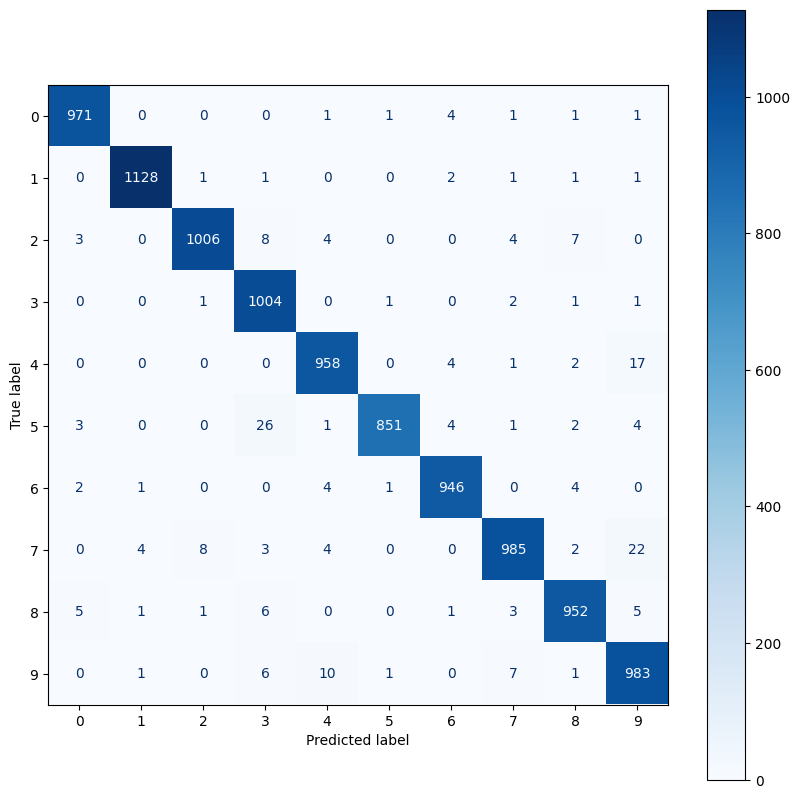

In [ ]:
#그래프 출력
plot_confusion_matrix(labels, pred_labels)

In [ ]:
#예측 정답 여부 확인
corrects = torch.eq(labels, pred_labels)

In [ ]:
#틀린 데이터 확인
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

In [ ]:
#틀린 데이터 시각화
def plot_most_incorrect(incorrect, n_images):

    #이미지의 크기만큼 그림판 생성
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20,10)) #그림판 생성
    for i in range(rows*cols): #이미지 크기만큼 반복
        ax = fig.add_subplot(rows, cols, i+1) #서브플롯 생성
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f}\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off') #그래프 눈금 지우기
    fig.subplots_adjust(hspace=0.5)

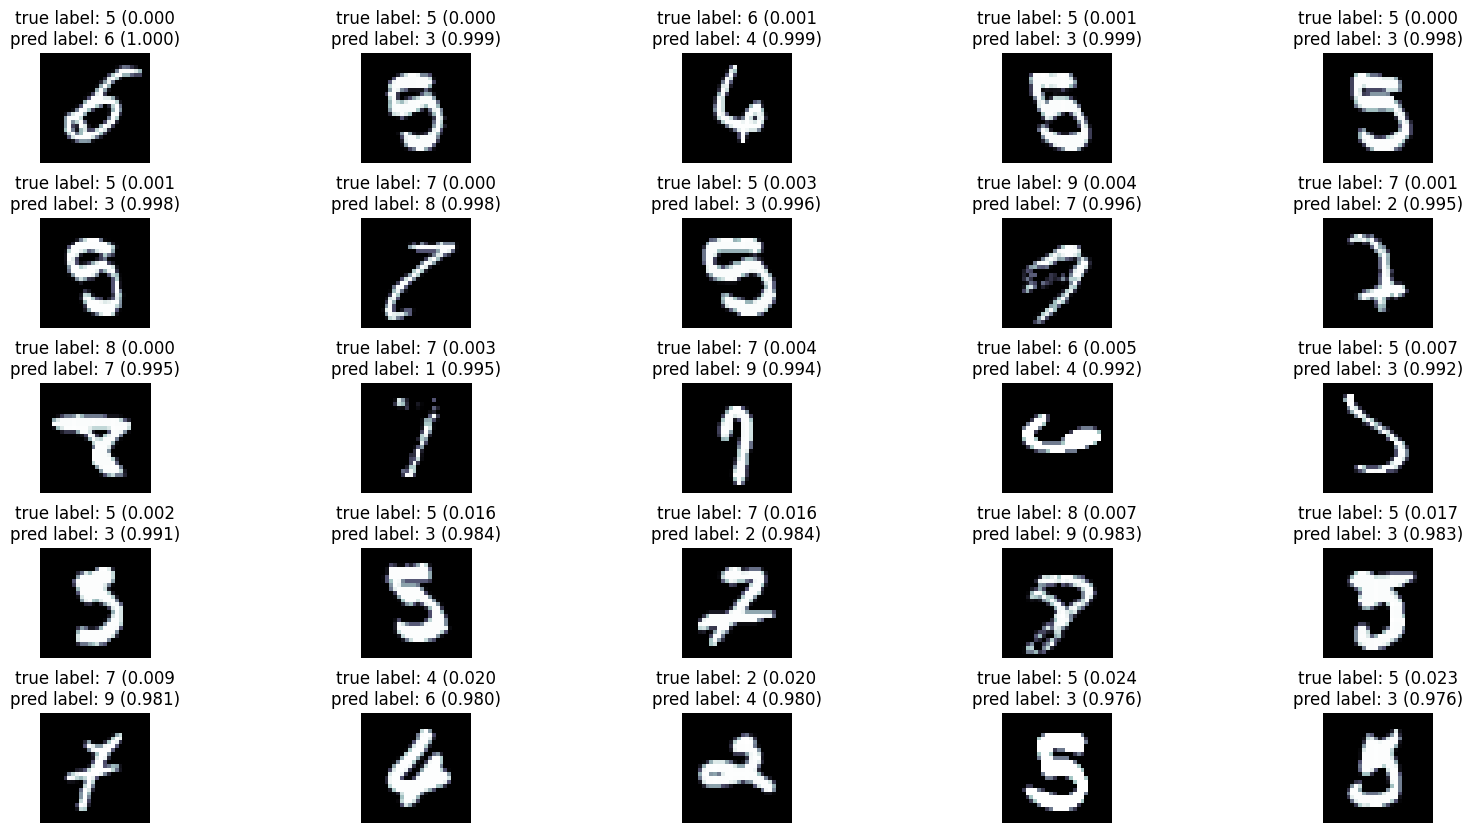

In [ ]:
#확인
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

In [ ]:
#모델의 생각과정 출력
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y.cpu())

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)
    return outputs, intermediates, labels

In [ ]:
#출력
outputs, intermediates, labels = get_representations(model, test_iterator, device)

  0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
#주성분 분석(PCA) 함수
def get_pca(data, n_components=2):
    pca = decomposition.PCA() #사이킷런 라이브러리에서 PCA 꺼냄
    pca.n_components = n_components #데이터를 몇차원으로 줄일지 결정
    pca_data = pca.fit_transform(data) #데이터의 특징 파악 후
    return pca_data

PCA 역할
- 차원 축소: 데이터 셋의 변수가 너무 많을 때 데이터가 가진 핵심 정보를 최대한 유지하면서 변수의 수 줄인다. 이는 데이터 분석 및 처리 속도를 향상시킨다.
- 데이터 전처리: 복잡한 데이터를 단순화하여 모델의 과적합 방지.

작동 원리
1. 새로운 축 설정: 데이터의 분산이 가장 큰 방향(정보량이 많은 방향)을 첫 번째 주성분으로 지정
2. 직교성: 그 다음 주성분들은 이전 주성분들과 상관관계가 없도록 설정한다.
3. 정보 보존: 분산이 큰 주성분들만 선택적으로 사용하여 원본 데이터의 가장 중요한 정보를 보존하면서 차원을 축소한다.


In [ ]:
#생각 과정 시각화 함수
def plot_representations(data, labels, n_images=None):
    if n_images is not None: #데이터의 수에 제한이 걸려있다면
        data = data[:n_images] #그 수만큼의 데이터만 사용
        labels = labels[:n_images] #그 수만큼의 정답만 사용
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10') #점 찍기
    #범례 달기
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

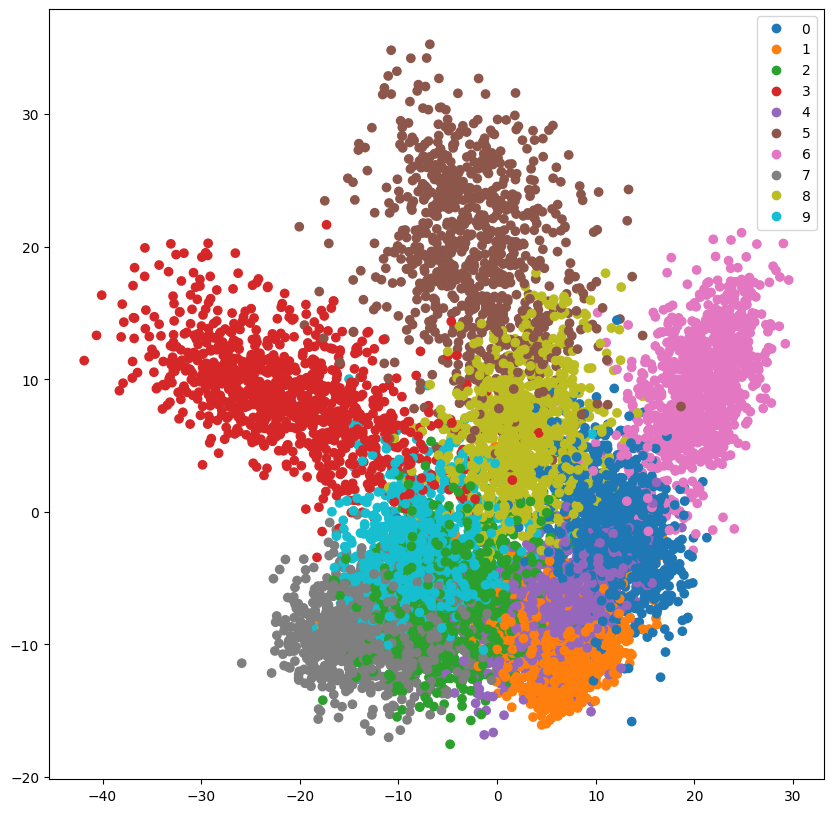

In [ ]:
#출력층의 특징 시각화
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

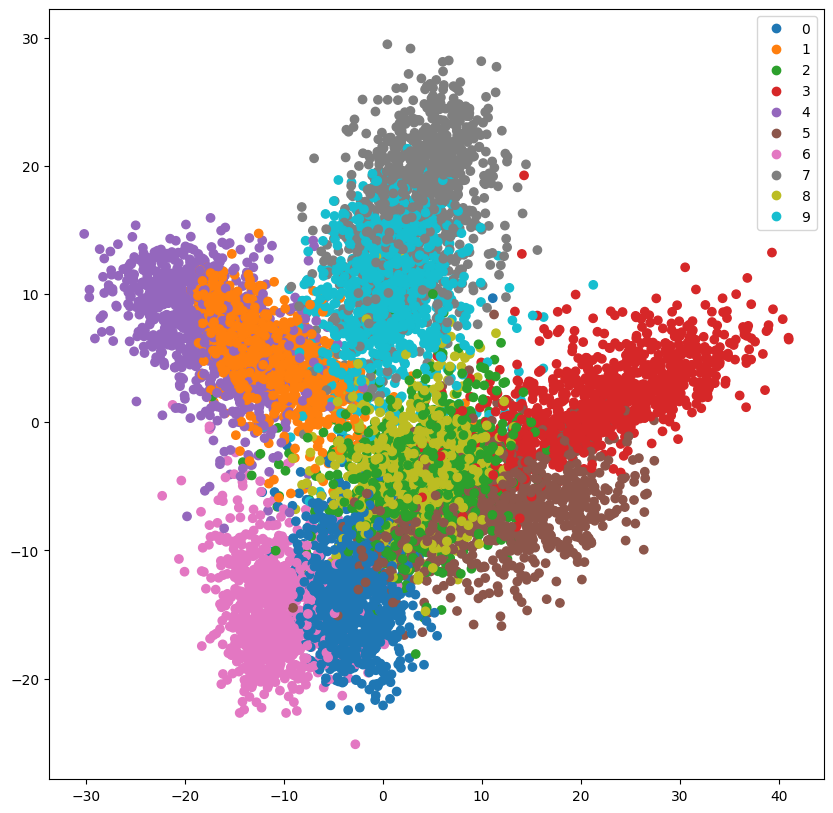

In [ ]:
#두 번째 은닉층의 특징 시각화
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

In [ ]:
#t-SNE 함수
def get_tsne(data, n_components=2, n_images=None):
    #데이터 개수 줄이기(PCA보다 속도가 느리기 때문)
    if n_images is not None:
        data = data[:n_images]

    tsne = manifold.TSNE(n_components=n_components, random_state=0) #manifold: t-SNE가 들어있는 상자, random_state=0: 실행할 때마다 그림이 달라지지 않게 고정
    tsne_data = tsne.fit_transform(data) #변환하기
    return tsne_data

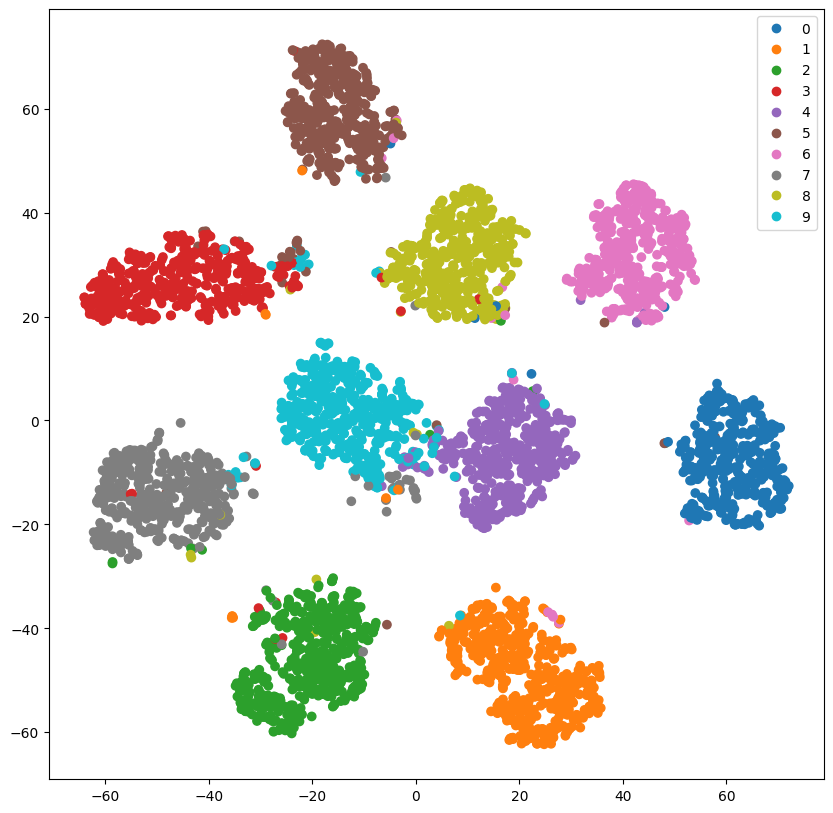

In [ ]:
#5000개의 데이터만 출력
N_IMAGES = 5_000 #5,000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES) #t-SNE로 데이터를 2차원으로 압축(5000개만 압축)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES) #점 찍기

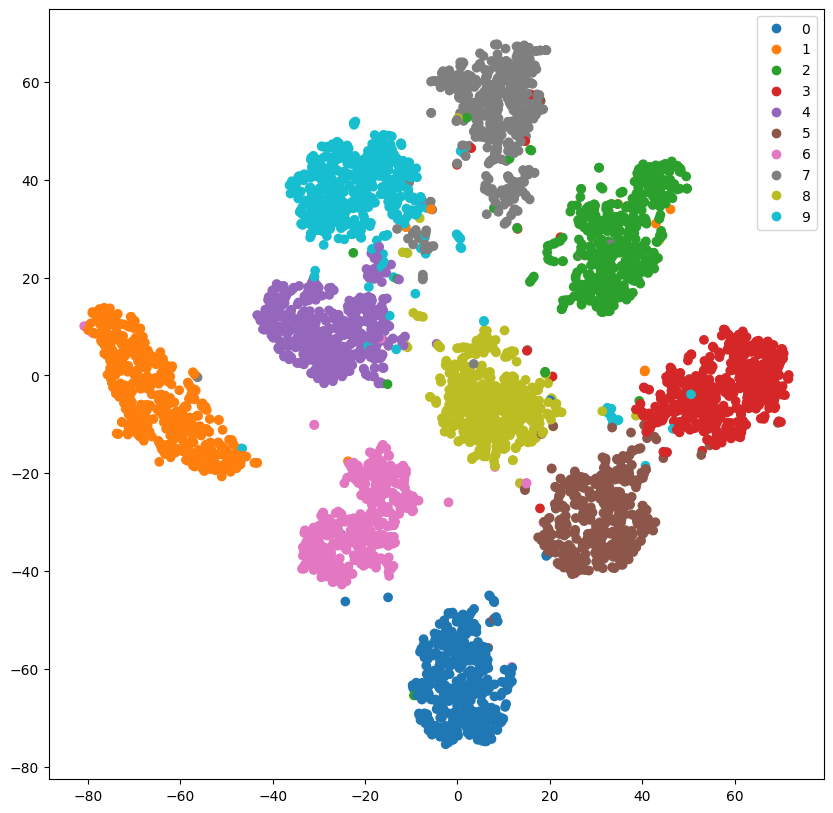

In [ ]:
#중간 은닉층 결과 시각화
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

In [ ]:
import os
import json

# ▼ 찾으려는 파일 이름 (이 부분은 맞게 적어주셨으니 그대로 둡니다)
target_filename = "Classification_Practice.ipynb"
output_filename = "github_upload_version.ipynb" # 결과물 파일 이름

print(f"🔍 전체 폴더에서 '{target_filename}' 파일을 검색 중입니다...")

found_path = None
# 코랩의 전체 폴더(/content)를 뒤져서 파일을 찾습니다
for root, dirs, files in os.walk("/content"):
    if target_filename in files:
        found_path = os.path.join(root, target_filename)
        break

if found_path:
    print(f"✅ 파일을 찾았습니다! 위치: {found_path}")
    print("🧹 청소 작업을 시작합니다...")

    try:
        # 1. 파일 열기
        with open(found_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # 2. 문제의 'widgets' 삭제 (출력 결과는 건드리지 않음)
        if 'widgets' in data['metadata']:
            del data['metadata']['widgets']
            print("✨ 성공: 오류를 일으키는 'widgets' 설정을 제거했습니다.")
        else:
            print("ℹ️ 참고: 삭제할 'widgets' 설정이 발견되지 않았습니다. (이미 깨끗하거나 원인이 다를 수 있음)")

        # 3. 저장하기
        # 저장 위치는 찾기 쉽게 무조건 '/content' 바로 아래에 저장합니다.
        save_path = f"/content/{output_filename}"
        with open(save_path, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=1)

        print("-" * 30)
        print(f"🎉 완료! 왼쪽 파일 목록(새로고침)에서 '{output_filename}' 파일을 다운로드하세요.")
        print("-" * 30)

    except Exception as e:
        print(f"❌ 작업 중 오류가 발생했습니다: {e}")

else:
    print("❌ 파일을 찾을 수 없습니다.")
    print("👉 힌트: 왼쪽 메뉴에서 '드라이브 마운트' 버튼을 눌러 구글 드라이브를 먼저 연결해주세요.")

🔍 전체 폴더에서 'Classification_Practice.ipynb' 파일을 검색 중입니다...
